In [1]:
#compute the uDFT by noting DFT.DFT^* = D, a diagonal matrix, and factoring as D = RR^*, so uDFT = R^{-1}.DFT
#alternately, one could use unitary representations and normalization factors \sqrt{d_\rho/|G|}
#the resulting DFT will have signs \pm 1 on the diagonal DFT.DFT^* = S, which can be factored as s = rr^*, so S=RR^*
#again, uDFT = R^{-1}.DFT

In [1]:
#for u in GF(q), we can factor as u=aa^* using gen. z and modular arithmetic
def conj_square_root(u):
    if u == 0:
        return 0  # Special case for 0
    z = F.multiplicative_generator()
    k = u.log(z)  # Compute discrete log of u to the base z
    if k % (q+1) != 0:
        raise ValueError("Unable to factor: u is not in base field GF(q)")
    return z ** ((k//(q+1))%(q-1))

In [2]:
#compute the uDFT by noting DFT.DFT^* = D, a diagonal matrix, and factoring as D = RR^*, so uDFT = R^{-1}.DFT
def unitary_dft():
    dft_matrix = SGA.dft()
    sign_diag = (dft_matrix*dft_matrix.H).diagonal()
    factor_diag_inv = diagonal_matrix([~conj_square_root(d) for d in sign_diag])
    return factor_diag_inv*dft_matrix

In [92]:
#parameters and define the symmetric group algebra
n = 4; q = 7
F = GF(q**2)
SGA = SymmetricGroupAlgebra(F,n)
assert F.characteristic() > 0, "F must have positive characteristic"
if not (F.is_field() and F.is_finite() and F.order().is_square()):
    raise ValueError("the base ring must be a finite field of square order")
if F.characteristic().divides(SGA.group().cardinality()):
    raise NotImplementedError("not implemented when p|n!; dimension of invariant forms may be greater than one")

In [93]:
#converting the unitary DFT over finite fields to a complex matrix using the root of unity map
U = unitary_dft();

In [77]:
#check that U is unitary over a finite field
U*U.H == 1

True

In [121]:
#given a multiplicative generator `z` of the finite field, the discrete_log is the exponent of the generator
#the discrete_log of zero is -infinity, which we set to -1 for convenience since all other values are nonnegative
z = F.multiplicative_generator()
discrete_log = lambda x: x.log(z) if x != 0 else -1

In [124]:
#compute the discrete log of each entry of U
log_U = U.apply_map(discrete_log)

In [95]:
U

24 x 24 dense matrix over Finite Field in z2 of size 7^2 (use the '.str()' method to see the entries)

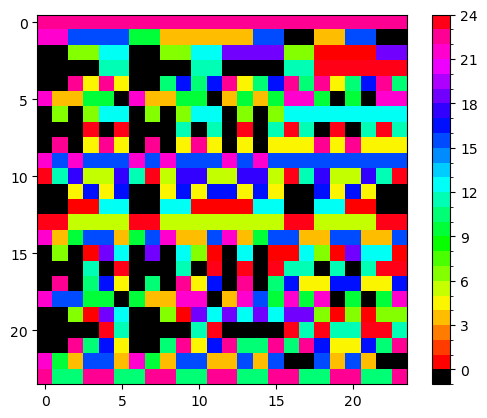

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

cmap = plt.cm.hsv  # Get the HSV colormap
new_colors = np.vstack(([0, 0, 0, 1], cmap(np.linspace(0, 1, F.order()))))  # Add black as the first color
custom_cmap = ListedColormap(new_colors) # create a new custom colormap
norm = BoundaryNorm([-1]+[i for i in range(F.order())], custom_cmap.N)  # Maps -1 to black, 0 to the first color of HSV

# Plotting the data
plt.imshow(log_U, cmap=custom_cmap, norm=norm, interpolation="nearest")
plt.colorbar()
plt.show()

In [96]:
#the map from modular representation theory to compute Brauer characters from F_q --> \C giving roots of unity
brauer_map = lambda a, F: 0 if a == 0 else exp(2*pi*I*a.log(F.multiplicative_generator())/(F.order()-1))

In [97]:
#complexify the uDFT matrix over F_q using the Brauer map
U_complex = matrix(CC,[[brauer_map(U[(i,j)],F) for j in range(U.nrows())] for i in range(U.nrows())])

In [98]:
#compute the Gram matrix, taking inner products of rows and columns w.r.t conjugate inner product
gram = U_complex*U_complex.H

In [99]:
#function to round each component of a complex number 
def round_complex(z, digits):
    if z.imag_part():
        return round(z.real_part(), digits) + round(z.imag_part(), digits) * I
    return round(z, digits)

In [100]:
#round the (complex) Gram matrix to three decimal places
gram_rounded = gram.apply_map(lambda u:round_complex(u,3))

In [101]:
#plot the complexified version of the uDFT matrix over a finite field
def plot_complex(U_complex):
    U_arg = U_complex.apply_map(lambda x: arg(x))  # find the argument of each element
    return matrix_plot(U_arg, cmap='hsv', colorbar=True)  # plot the matrix

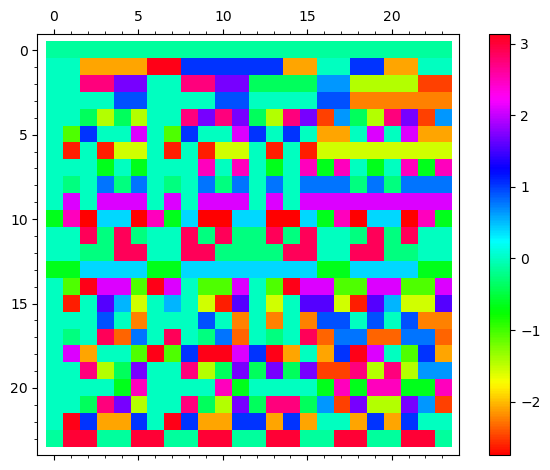

In [102]:
#plot the complexified version of the uDFT matrix over a finite field
plot_complex(U_complex)

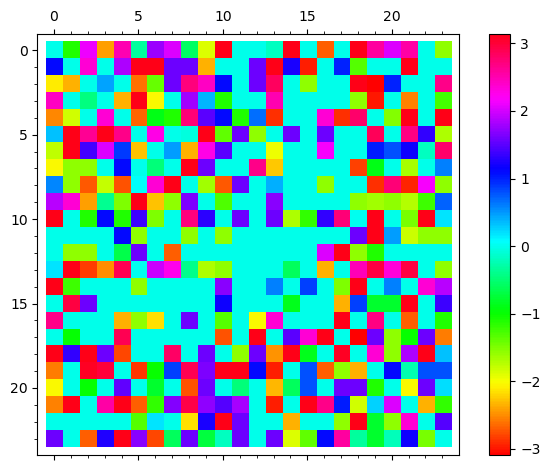

In [103]:
#plot the result of U_complex*U_complex.H to see how far it is from being unitary over the complex numbers
plot_complex(gram)

In [119]:
#compute the eigenvalues of the uDFT matrix
eigenvalues = U.eigenvalues()

In [112]:
#compute the multiplicity of each eigenvalue. check if all eigenvalues are distinct
from collections import Counter
multiplicities = Counter(eigenvalues)
all_unique = all(count == 1 for count in multiplicities.values()); all_unique

True

In [107]:
#compute the charpoly of the uDFT matrix 
charpoly = U.charpoly(); charpoly

x^24 + z2*x^23 + (2*z2 + 2)*x^22 + (4*z2 + 4)*x^21 + (2*z2 + 6)*x^20 + 4*z2*x^19 + 2*z2*x^18 + (4*z2 + 3)*x^17 + (4*z2 + 6)*x^16 + (5*z2 + 2)*x^15 + 2*z2*x^14 + (6*z2 + 2)*x^13 + 5*z2*x^11 + (z2 + 5)*x^10 + (z2 + 1)*x^9 + z2*x^8 + (5*z2 + 5)*x^7 + (z2 + 5)*x^6 + (2*z2 + 3)*x^5 + 2*x^4 + (6*z2 + 1)*x^3 + (3*z2 + 4)*x^2 + (4*z2 + 6)*x + z2 + 3

In [118]:
#compute a splitting field of the characteristic polynomial
K = charpoly.splitting_field('a'); K

Finite Field in a of size 7^210

In [128]:
#compute the discrete log of the eigenvalues
log_eigenvalues = list(map(discrete_log, eigenvalues)); log_eigenvalues

AttributeError: 'AlgebraicClosureFiniteField_pseudo_conway_with_category.element_class' object has no attribute 'log'

In [129]:
#compute the complexified eigenvalue
complex_eigenvalues = [to_root_of_unity(eig[0],K) for eig in eigenvalues]

TypeError: 'AlgebraicClosureFiniteField_pseudo_conway_with_category.element_class' object is not subscriptable

In [134]:
import matplotlib.pyplot as plt
import numpy as np

# Extract real and imaginary parts for plotting
real_parts = [eig.real() for eig in complex_eigenvalues]
imaginary_parts = [eig.imag() for eig in complex_eigenvalues]

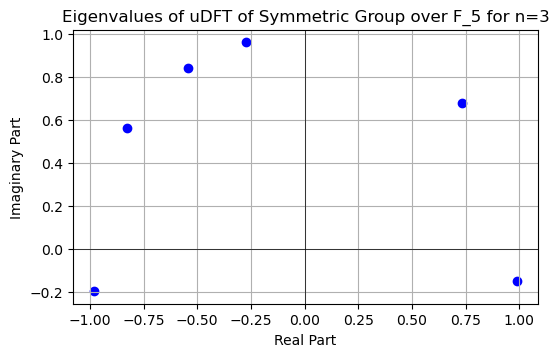

In [135]:
# Plotting the eigenvalues on the complex plane
plt.figure(figsize=(6,6))
plt.scatter(real_parts, imaginary_parts, color='blue', label="Eigenvalues")
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(f'Eigenvalues of uDFT of Symmetric Group over F_{q} for n={n}')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.grid(True)
plt.show()